In [2]:
'''
Credit goes to Mr. Georgio for creating the very helpful modules used in this file.
'''

'\nCredit goes to Mr. Georgio for creating the very helpful modules used in this file.\n'

In [3]:
from pyscf import gto,scf, cc
import numpy as np
import pyscf
import matplotlib.pyplot as plt
import basis_set_exchange as bse
from FcMole import FcM, FcM_like
def generate_table(data):
    # Determine the maximum width of each column
    column_widths = [max(len(str(row[i])) for row in data) for i in range(len(data[0]))]

    # Generate the table header
    table = generate_table_row(data[0], column_widths)
    table += generate_table_row(['-' * width for width in column_widths], column_widths)

    # Generate the table rows
    for row in data[1:]:
        table += generate_table_row(row, column_widths)

    return table

def generate_table_row(row_data, column_widths):
    row = '|'
    for i, item in enumerate(row_data):
        row += f' {str(item):{column_widths[i]}} |'
    row += '\n'
    return row

In [4]:
%load_ext autoreload
%autoreload 2
from AP_class import APDFT_perturbator as AP

#### Verifying electronic energy curve

In [5]:
# def calc_elec_energy(separation):
#     mol = gto.M(atom= f"N 0 0 0; N 0 0 {separation}",unit="Bohr",basis=bse.get_basis('pcX-2',fmt="nwchem",elements=[5,6,7,8,9]))
#     mol_conv= scf.RHF(mol)
#     return mol_conv.scf() - 7*7/separation

In [6]:
# x = 0
# distances = []
# energies = []
# while x < 1:
#     distances.append(x)
#     energies.append(calc_elec_energy(x))
#     x+= 0.3
# plt.plot(distances, energies)

In [7]:
'''
Things to do: calculate CCSD, RKS energies.  Done
Assume current calculated one and use Hessian to predict energies 
and see whether they are nearby for the other two compounds. Done.

see if the nl gradients make sense: from CO, NN pred must be
closer to NN actual than that of BF. 

Check issue of NN slope 0
'''

'\nThings to do: calculate CCSD, RKS energies.  Done\nAssume current calculated one and use Hessian to predict energies \nand see whether they are nearby for the other two compounds. Done.\n\nsee if the nl gradients make sense: from CO, NN pred must be\ncloser to NN actual than that of BF. \n\nCheck issue of NN slope 0\n'

In [8]:
# # calculate CCSD 
# NN = gto.M(atom= f"N 0 0 0; N 0 0 2.1",unit="Bohr",basis='unc-ccpvdz')
# CO =  gto.M(atom= f"C 0 0 0; O 0 0 2.267671",unit="Bohr",basis='unc-ccpvdz')
# BF = FcM_like(NN,fcs=[-2,2])

# print(cc.CCSD(scf.HF(CO).run()).run().ccsd_t())
    
'''
NN total energy CCSD(t)  = -109.36
'''

'\nNN total energy CCSD(t)  = -109.36\n'

### Defining my molecules

In [9]:
# uncontracted cc-pvdz
d = 2.1
NN = gto.M(atom= f"N 0 0 0; N 0 0 {d}",unit="Bohr",basis='unc-ccpvdz')
CO = FcM_like(NN,fcs=[-1,1])
BF = FcM_like(NN,fcs=[-2,2])

# Restricted HF
# mol_NN = scf.RHF(NN)
# mol_CO= scf.RHF(CO)
# mol_BF= scf.RHF(BF)

# using PBE0 with RKS
mol_NN=scf.RKS(NN)
mol_NN.xc="PBE0"
mol_CO=scf.RKS(CO)
mol_CO.xc="PBE0"
mol_BF=scf.RKS(BF)
mol_BF.xc="PBE0"


Te_NN=mol_NN.scf(dm0=mol_NN.init_guess_by_1e())
Te_CO=mol_CO.scf(dm0=mol_CO.init_guess_by_1e())
Te_BF=mol_BF.scf(dm0=mol_BF.init_guess_by_1e())

converged SCF energy = -109.4150800176


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyscf/gto/mole.py:1213: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -113.178333785775
converged SCF energy = -124.408104202864


In [10]:
'''calculating energy via RKS for complete CO'''
# CO_ = gto.M(atom= f"C 0 0 0; O 0 0 2.267671",unit="Bohr",basis='unc-ccpvdz')
# mol_CO_=scf.RKS(CO_)
# mol_CO_.xc="PBE0"
# mol_CO_.scf(dm0=mol_CO_.init_guess_by_1e()) - np.prod(CO.atom_charges()) / d

'calculating energy via RKS for complete CO'

## Calculating their electronic energies

In [11]:
# Subtracting nuclear repulsion from total energy to calculate total electronic energy
e_NN = round(Te_NN - np.prod(NN.atom_charges()) / d,3)
e_CO = round(Te_CO - np.prod(CO.atom_charges()) / d,3)
e_BF = round(Te_BF - np.prod(BF.atom_charges()) / d,3)
print(e_NN, e_CO, e_BF)

-132.748 -136.035 -145.837


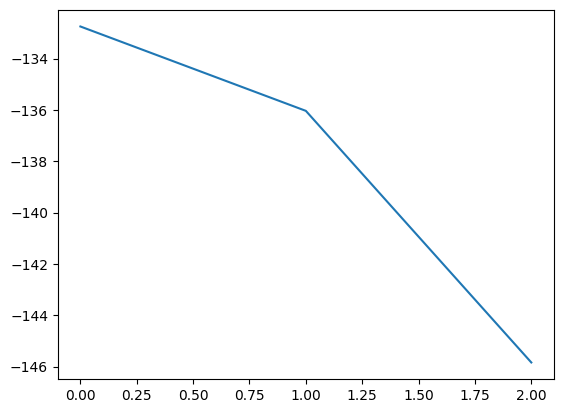

In [12]:
plt.plot([e_NN, e_CO, e_BF])

In [13]:
def d_Z_lambda(mol_i, mol_f,lam):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    e = 7/3
    num = (3/7)* (Z_f**e - Z_i**e)
    den = ((Z_i**e) + lam*(Z_f**e - Z_i**e))**(4/7)
    return num / den

def Z_diff(mol_i, mol_f):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    return Z_f - Z_i

### Gradients from NN to CO and BF

In [14]:
# Evaluating the linearized energy gradient at lambda = 0
lam = 0

ap_NN=AP(mol_NN,sites=[0,1])
AG_NN = ap_NN.build_gradient()  - np.array([NN.atom_charges()[1],NN.atom_charges()[0]]) / d 

# calculating linear and non-linear energy gradients
nl_grad_NN_to_CO = round(np.dot(Z_diff(NN, CO), AG_NN),3)
l_grad_NN_to_CO = round(np.dot(d_Z_lambda(NN,CO,lam), AG_NN),3)

nl_grad_NN_to_BF = round(np.dot(Z_diff(NN, BF), AG_NN),3)
l_grad_NN_to_BF = round(np.dot(d_Z_lambda(NN,BF,lam), AG_NN),3)

In [15]:
A_N1  = AG_NN[0]*3/7*7**(-4/3)
E_CO_pred = e_NN + A_N1*( 6**(7/3)+8**(7/3)-2*7**(7/3))
E_CO_pred

-136.8681760876302

### Gradients from CO to NN and BF

In [16]:
# Evaluating the linearized energy gradient at lambda = 0
lam = 0

ap_CO=AP(mol_CO,sites=[0,1])
AG_CO = ap_CO.build_gradient() - np.array([CO.atom_charges()[1],CO.atom_charges()[0]]) / d 

# calculating linear and non-linear energy gradients
nl_grad_CO_to_NN = round(np.dot(Z_diff(CO, NN), AG_CO),3)
l_grad_CO_to_NN = round(np.dot(d_Z_lambda(CO,NN,lam), AG_CO),3)

nl_grad_CO_to_BF = round(np.dot(Z_diff(CO, BF), AG_CO),3)
l_grad_CO_to_BF = round(np.dot(d_Z_lambda(CO,BF,lam), AG_CO),3)

In [17]:
'''
Making predictions of NN and BF from CO using the non-lin
'''
NN_p = e_CO + nl_grad_CO_to_NN
BF_p = e_CO + nl_grad_CO_to_BF
print(NN_p, BF_p)


-129.47 -142.6


In [18]:
nl_grad_CO_to_NN, l_grad_CO_to_NN, nl_grad_CO_to_BF, l_grad_CO_to_BF

(6.565, 2.407, -6.565, -10.704)

### Gradients from BF to CO and NN

In [19]:
# Evaluating the linearized energy gradient at lambda = 0
lam = 0

ap_BF=AP(mol_BF,sites=[0,1])
AG_BF = ap_BF.build_gradient() - np.array([BF.atom_charges()[1],BF.atom_charges()[0]]) / d 

# calculating linear and non-linear energy gradients
nl_grad_BF_to_NN = round(np.dot(Z_diff(BF, NN), AG_BF),3)
l_grad_BF_to_NN = round(np.dot(d_Z_lambda(BF,NN,lam), AG_BF),3)

nl_grad_BF_to_CO = round(np.dot(Z_diff(BF, CO), AG_BF),3)
l_grad_BF_to_CO = round(np.dot(d_Z_lambda(BF,CO,lam), AG_BF),3)

In [20]:
NN_p = e_CO + nl_grad_BF_to_NN
CO_p = e_CO + nl_grad_BF_to_CO
print(NN_p, CO_p)

-110.024 -123.029


In [21]:
nl_grads= np.array([nl_grad_CO_to_NN, nl_grad_CO_to_BF,
                    nl_grad_BF_to_NN, nl_grad_BF_to_CO])

l_grads= np.array([l_grad_CO_to_NN, l_grad_CO_to_BF,
                    l_grad_BF_to_NN, l_grad_BF_to_CO])

# nl_grads = np.append(nl_grads,[nl_grad_NN_to_BF, nl_grad_NN_to_CO])
# l_grads = np.append(l_grads,[l_grad_NN_to_BF, l_grad_NN_to_CO])


## getting average linearizing coeffecient = ratio of nl_grad to l_grad

In [22]:
C = np.mean(l_grads / nl_grads)

In [23]:
NN_pred = ['NN','-', e_NN + C *nl_grad_NN_to_CO ,  e_NN + C *nl_grad_NN_to_BF]
CO_pred = ['CO',e_CO + C *nl_grad_CO_to_NN,'-' ,  e_CO + C *nl_grad_CO_to_BF]
BF_pred = ['BF',e_BF + C *nl_grad_BF_to_NN,e_BF + C *nl_grad_BF_to_CO,'-' ]

# finding nl_E predictions
# NN_pred = 


In [24]:
# Example usage
data = [
    ['From \ To', 'NN', 'CO','BF'],
    ['NN','-', e_NN + C *nl_grad_NN_to_CO ,  e_NN + C *nl_grad_NN_to_BF],
    ['CO',e_CO + C *nl_grad_CO_to_NN,'-' ,  e_CO + C *nl_grad_CO_to_BF],
    ['BF',e_BF + C *nl_grad_BF_to_NN,e_BF + C *nl_grad_BF_to_CO,'-' ]
]
table = generate_table(data)
print('Using average of linearizing coeffecient at CO and BF')
print()
print(table)
print(f'NN actual energy = {e_NN}, \nCO actual energy = {e_CO}, \nBF actual energy = {e_BF}, \n')

Using average of linearizing coeffecient at CO and BF

| From \ To | NN                 | CO                  | BF                 |
| --------- | ------------------ | ------------------- | ------------------ |
| NN        | -                  | -132.748            | -132.748           |
| CO        | -131.0918757706635 | -                   | -140.9781242293365 |
| BF        | -126.2519879163334 | -136.04411748259707 | -                  |

NN actual energy = -132.748, 
CO actual energy = -136.035, 
BF actual energy = -145.837, 



In [25]:
print('Predictions from CO and BF just using non-linear energy gradient')
print()
data = [
    ['From \ To', 'NN','err','CO','err','BF','err'],
    ['CO',e_CO + nl_grad_CO_to_NN,round(e_CO + nl_grad_CO_to_NN - e_NN,3),'-','-', e_CO + nl_grad_CO_to_BF,round(e_CO + nl_grad_CO_to_BF-e_BF,3)],
    ['BF',e_BF + nl_grad_BF_to_NN,round(e_BF + nl_grad_BF_to_NN - e_NN,3),e_BF + nl_grad_BF_to_CO,round(e_BF + nl_grad_BF_to_CO - e_CO,3),'-','-' ]
]
table = generate_table(data)
print(table)
print(f'NN actual energy = {e_NN}, \nCO actual energy = {e_CO}, \nBF actual energy = {e_BF}, \n')

Predictions from CO and BF just using non-linear energy gradient

| From \ To | NN       | err    | CO       | err   | BF     | err   |
| --------- | -------- | ------ | -------- | ----- | ------ | ----- |
| CO        | -129.47  | 3.278  | -        | -     | -142.6 | 3.237 |
| BF        | -119.826 | 12.922 | -132.831 | 3.204 | -      | -     |

NN actual energy = -132.748, 
CO actual energy = -136.035, 
BF actual energy = -145.837, 



In [28]:
'''Using Hessian'''
# modelling ax^2 + bx + c
a = -0.139 - 2 * 3.126
b = 0
c = -132.748
def app(l):
    return round(a*l**2 + b*l + c,3)

print('Prediction of energies via the Hessian')
print()
data = [['Mol \ Method', 'Actual (PBE; unc-ccpvdz with RKS)','Hessian from paper','Descrepency'],
        [
            'NN',e_NN, app(0),e_NN-app(0), 
        ],
         [
            'CO',e_CO, app(1),round(e_CO-app(1),3), 
        ],
          [
            'BF',e_BF, app(2),round(e_BF-app(2),3), 
        ]
        
        ]
table = generate_table(data)
print(table)

Prediction of energies via the Hessian

| Mol \ Method | Actual (PBE; unc-ccpvdz with RKS) | Hessian from paper | Descrepency |
| ------------ | --------------------------------- | ------------------ | ----------- |
| NN           | -132.748                          | -132.748           | 0.0         |
| CO           | -136.035                          | -139.139           | 3.104       |
| BF           | -145.837                          | -158.312           | 12.475      |

